<a href="https://www.kaggle.com/code/mateusbaldamota/eeg-psychiatric-disorders-using-ann?scriptVersionId=208046534" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Description

Author of notebook: Mateus Balda

Paper: https://www.frontiersin.org/journals/psychiatry/articles/10.3389/fpsyt.2021.707581/full

## Import from libraries

In [1]:
!pip install -q torchsummary;
!pip install -q torchviz;

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv
import os

from xgboost import XGBClassifier
from IPython.display import FileLink
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from torchviz import make_dot

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

from warnings import filterwarnings
filterwarnings('ignore')

torch.__version__

'2.4.0+cpu'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
np.random.seed(123)
torch.manual_seed(123)

## Load dataset

In [5]:
df = pd.read_csv('../input/eeg-psychiatric-disorders-dataset/EEG.machinelearing_data_BRMH.csv')

column = 'Unnamed: 122' # column 122 is nan
df = df.drop(columns=[column])

# only PSD and FC
X_1 = df.iloc[:,8:]
y = df['main.disorder']

# quantitative variables
X_2 = df.loc[:, ['age', 'education', 'IQ']]

X_1.shape, X_2.shape, y.shape

((945, 1140), (945, 3), (945,))

### Checking/imputing Nan

In [6]:
def analyze_missing_values(dataframe):
    number_of_na_by_column = dataframe.isnull().sum().loc[lambda x: x > 0]
    
    number_of_na_rows = dataframe.isnull().any(axis=1).sum()
    
    #display(number_of_na_by_column)
    
    return number_of_na_by_column, number_of_na_rows

In [7]:
# X_1

analyze_missing_values(X_1)

(Series([], dtype: int64), 0)

In [8]:
# X_2

analyze_missing_values(X_2)

(education    15
 IQ           13
 dtype: int64,
 26)

In [9]:
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

df_imput = pd.DataFrame(knn_imputer.fit_transform(X_2[['education', 'IQ']]), columns=['education', 'IQ'])

X_2[['education', 'IQ']] = df_imput[['education', 'IQ']]

In [10]:
analyze_missing_values(X_2)

(Series([], dtype: int64), 0)

### Target `y` variable classes

`y` = main.disorder

In [11]:
column_names = np.unique(y).tolist()
column_names

['Addictive disorder',
 'Anxiety disorder',
 'Healthy control',
 'Mood disorder',
 'Obsessive compulsive disorder',
 'Schizophrenia',
 'Trauma and stress related disorder']

In [12]:
pd.DataFrame(np.unique(y))

,0
0,Addictive disorder
1,Anxiety disorder
2,Healthy control
3,Mood disorder
4,Obsessive compulsive disorder
5,Schizophrenia
6,Trauma and stress related disorder


### Class encoder

In [13]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = y_encoded.astype(np.float32)

In [14]:
pd.DataFrame(y_encoded).value_counts()

0  
3.0    266
0.0    186
6.0    128
5.0    117
1.0    107
2.0     95
4.0     46
Name: count, dtype: int64

### Transf log

In [15]:
X_2 = np.log1p(X_2)
X_2

,age,education,IQ
0,4.060443,2.669913,4.630648
1,3.637586,1.945910,4.795791
2,3.496508,2.833213,4.736198
3,3.583519,2.944439,4.844187
4,3.610918,2.833213,4.727388
...,...,...,...
940,3.135494,2.639057,4.762174
941,3.295837,2.639057,4.779123
942,3.295837,2.833213,4.736198
943,3.218876,2.639057,4.682131


## Feature importance/selection

In [16]:
def train_xgb_model(X, y, test_size=0.2, random_state=42, n_estimators=100, max_depth=6, learning_rate=0.1):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)
    
    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    
    model.fit(X_train, y_train)
    
    return model, X_train, X_test, y_train, y_test

In [17]:
model_xgb, X_train, X_test, y_train, y_test = train_xgb_model(X_1, y_encoded)

In [18]:
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3016


In [19]:
importances = model_xgb.feature_importances_

indices = np.argsort(importances)[::-1]

selected_number = int((X_1.shape[1])/10)

top_features = indices[:selected_number]

top_features

array([ 888,  258,  821,  929,  766,  345,  458,  190, 1067,  884,  578,
       1132,  750,  259,  755,  277,  956,  315,  982,  371,  434,  206,
        689,   29,  777,  653,  132,  247,  993,  839, 1029,   28,  713,
        848,  719,  800, 1103,  782,  126,  149,  920,  636,  214,   94,
       1023,  881,  433,  847,  108,  998,  891, 1021,  887,  897,  482,
        226, 1137,  908,   98,  460,  976,  342,  972,  587,  771,  632,
        567,  308, 1120, 1053,  377,  871,  137,  831,  634,  593,  168,
        161,  422,  852,   60, 1106,  688,  718, 1006,  353,  810, 1117,
       1059,  704,  903,  676,  391,  491,  664,  117, 1049,  595,   51,
        679,  862,   16,  971,  507,  439,  845,  621,  787,  366,  613,
        107,   39,  589,  949])

In [20]:
X_1_top_features = X_1.iloc[:, top_features]
X_2_top_features = pd.concat([X_2, X_1_top_features], axis=1)

X_2_quanti = pd.concat([X_2, X_1], axis=1)

In [21]:
X_1

,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,22.582176,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,10.950564,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,18.367666,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,11.639560,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,17.041979,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,7.520642,17.636528,20.220791,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,13.178851,12.687296,20.257619,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,11.368466,21.799254,36.083181,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,13.438102,17.442777,18.859586,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [22]:
X_2_quanti

,age,education,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,4.060443,2.669913,4.630648,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,3.637586,1.945910,4.795791,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3.496508,2.833213,4.736198,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,3.583519,2.944439,4.844187,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,3.610918,2.833213,4.727388,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,3.135494,2.639057,4.762174,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,3.295837,2.639057,4.779123,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,3.295837,2.833213,4.736198,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,3.218876,2.639057,4.682131,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [23]:
X_1_top_features

,COH.E.highbeta.f.F4.q.T6,COH.A.delta.l.T4.n.P3,COH.E.highbeta.b.FP2.h.T3,COH.E.highbeta.j.Cz.p.P4,COH.D.beta.k.C4.p.P4,COH.B.theta.d.F3.n.P3,COH.C.alpha.a.FP1.d.F3,COH.A.delta.e.Fz.p.P4,COH.F.gamma.g.F8.m.T5,COH.E.highbeta.f.F4.m.T5,...,COH.B.theta.m.T5.r.O1,COH.E.highbeta.c.F7.p.P4,COH.C.alpha.p.P4.q.T6,COH.D.beta.n.P3.s.O2,COH.B.theta.f.F4.h.T3,COH.C.alpha.n.P3.p.P4,AB.F.gamma.m.T5,AB.C.alpha.b.FP2,COH.C.alpha.j.Cz.r.O1,COH.E.highbeta.m.T5.o.Pz
0,5.243503,4.663925,0.934555,37.860251,62.899463,34.875095,90.729595,7.859443,1.067250,0.049278,...,10.173454,0.148287,39.658887,28.713693,14.920500,37.246889,1.501948,43.949575,17.943672,14.265242
1,4.733321,17.593305,8.271753,38.682828,62.334331,40.230334,93.251621,33.436522,7.724289,4.539366,...,53.518329,1.069509,35.974479,35.236759,34.546349,64.520306,0.930843,27.914361,8.428239,22.774359
2,20.804819,6.896782,17.138360,47.542757,60.271307,32.492601,84.155240,12.260879,52.188128,22.571789,...,34.134637,12.837796,72.516559,28.984787,27.781265,50.330605,1.133891,30.715669,4.226687,30.522151
3,31.212999,16.900022,16.660581,35.852934,54.229367,32.760473,92.787361,10.277232,17.281250,22.726818,...,50.938901,8.238156,97.374962,28.703657,40.211151,41.199742,1.648217,28.203285,19.278054,60.578841
4,56.753720,9.432810,34.913618,70.184423,72.196161,47.777310,94.332728,33.273582,62.468048,47.318980,...,42.834758,42.498648,63.226655,51.399252,18.713282,74.731594,1.441662,26.133568,18.317571,43.180663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,26.175875,22.706704,9.789128,55.869244,60.632945,63.220554,84.821902,40.536599,15.451615,25.299357,...,68.641899,5.253675,68.088448,61.117190,51.519512,54.857796,2.437923,30.654303,7.152004,73.943584
941,38.900886,89.331947,60.190382,37.155722,59.465918,52.446860,92.302428,79.870713,6.817854,15.919000,...,86.047732,28.168793,99.847209,33.275949,67.646765,34.367343,2.559590,6.314084,18.998841,36.452417
942,2.373644,0.562884,18.622572,25.372251,42.686060,4.800972,99.970571,3.941343,1.677547,0.007659,...,90.142179,2.672707,54.565176,10.459981,30.920001,23.994816,0.840513,4.913281,41.405299,16.120743
943,26.716959,22.896848,31.033780,58.761802,46.823214,35.600639,98.166471,33.014293,21.729877,15.623730,...,11.156671,22.508703,71.221013,18.051707,58.085827,82.361561,1.429330,94.531271,38.940646,36.230111


In [24]:
X_2_top_features

,age,education,IQ,COH.E.highbeta.f.F4.q.T6,COH.A.delta.l.T4.n.P3,COH.E.highbeta.b.FP2.h.T3,COH.E.highbeta.j.Cz.p.P4,COH.D.beta.k.C4.p.P4,COH.B.theta.d.F3.n.P3,COH.C.alpha.a.FP1.d.F3,...,COH.B.theta.m.T5.r.O1,COH.E.highbeta.c.F7.p.P4,COH.C.alpha.p.P4.q.T6,COH.D.beta.n.P3.s.O2,COH.B.theta.f.F4.h.T3,COH.C.alpha.n.P3.p.P4,AB.F.gamma.m.T5,AB.C.alpha.b.FP2,COH.C.alpha.j.Cz.r.O1,COH.E.highbeta.m.T5.o.Pz
0,4.060443,2.669913,4.630648,5.243503,4.663925,0.934555,37.860251,62.899463,34.875095,90.729595,...,10.173454,0.148287,39.658887,28.713693,14.920500,37.246889,1.501948,43.949575,17.943672,14.265242
1,3.637586,1.945910,4.795791,4.733321,17.593305,8.271753,38.682828,62.334331,40.230334,93.251621,...,53.518329,1.069509,35.974479,35.236759,34.546349,64.520306,0.930843,27.914361,8.428239,22.774359
2,3.496508,2.833213,4.736198,20.804819,6.896782,17.138360,47.542757,60.271307,32.492601,84.155240,...,34.134637,12.837796,72.516559,28.984787,27.781265,50.330605,1.133891,30.715669,4.226687,30.522151
3,3.583519,2.944439,4.844187,31.212999,16.900022,16.660581,35.852934,54.229367,32.760473,92.787361,...,50.938901,8.238156,97.374962,28.703657,40.211151,41.199742,1.648217,28.203285,19.278054,60.578841
4,3.610918,2.833213,4.727388,56.753720,9.432810,34.913618,70.184423,72.196161,47.777310,94.332728,...,42.834758,42.498648,63.226655,51.399252,18.713282,74.731594,1.441662,26.133568,18.317571,43.180663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,3.135494,2.639057,4.762174,26.175875,22.706704,9.789128,55.869244,60.632945,63.220554,84.821902,...,68.641899,5.253675,68.088448,61.117190,51.519512,54.857796,2.437923,30.654303,7.152004,73.943584
941,3.295837,2.639057,4.779123,38.900886,89.331947,60.190382,37.155722,59.465918,52.446860,92.302428,...,86.047732,28.168793,99.847209,33.275949,67.646765,34.367343,2.559590,6.314084,18.998841,36.452417
942,3.295837,2.833213,4.736198,2.373644,0.562884,18.622572,25.372251,42.686060,4.800972,99.970571,...,90.142179,2.672707,54.565176,10.459981,30.920001,23.994816,0.840513,4.913281,41.405299,16.120743
943,3.218876,2.639057,4.682131,26.716959,22.896848,31.033780,58.761802,46.823214,35.600639,98.166471,...,11.156671,22.508703,71.221013,18.051707,58.085827,82.361561,1.429330,94.531271,38.940646,36.230111


## Balance classes

In [25]:
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)

smote = BorderlineSMOTE(random_state=42)

X_top_resampled, y_top_resampled = smote.fit_resample(X_1_top_features, y_encoded)
X_2_top_resampled, y_2_top_resampled = smote.fit_resample(X_2_top_features, y_encoded)

X_all_features_resampled, y_all_features_resampled = smote.fit_resample(X_1, y_encoded)
X_2_all_features_resampled, y_2_top_resampled = smote.fit_resample(X_2_quanti, y_encoded)

In [26]:
pd.DataFrame(y_top_resampled).value_counts()

0  
0.0    266
1.0    266
2.0    266
3.0    266
4.0    266
5.0    266
6.0    266
Name: count, dtype: int64

In [27]:
pd.DataFrame(X_all_features_resampled)

,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,22.582176,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,10.950564,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,18.367666,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,11.639560,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,17.041979,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,16.562446,27.632508,16.263492,15.198508,11.377521,12.433356,15.015650,10.237094,8.603530,9.747749,...,64.346925,35.208785,30.477035,45.544706,60.318937,25.504687,64.975848,17.381227,66.919523,31.864837
1858,18.687103,24.936895,15.821645,15.227341,27.228849,14.924671,13.831693,9.707966,12.599548,17.799487,...,72.375301,41.632042,42.535414,48.481163,53.180884,27.594997,56.261067,22.550225,62.832313,38.900185
1859,30.282015,27.303971,18.488827,29.947922,40.152306,42.720962,23.889057,11.113195,23.334683,40.679022,...,65.218326,40.970966,38.002354,44.525671,55.284992,23.702585,54.976024,16.021336,63.466384,27.708143
1860,17.096277,15.041191,15.996200,18.376508,26.930359,19.653401,11.648074,11.263550,17.131067,24.131289,...,80.618166,53.869549,43.620611,59.287785,69.675702,35.963907,64.584703,21.209441,62.113842,47.125557


## Custom dataset PyTorch

In [28]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  
        self.y = torch.tensor(y, dtype=torch.long)   

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Split for train, val and test

In [29]:
scaler = StandardScaler()
scaler_type = type(scaler).__name__
train_ratio = 0.7
val_ratio = 0.15
batch_size = 32
output_dim = len(np.unique(y_encoded))

neurons = [1440, 700, 350, 150, 70]
neurons1 = [1024, 512, 256, 128, 64]
neurons2 = [512, 256, 128, 64, 32]
neurons3 = [256, 128, 64, 32, 16]

dropout = 0.15
learning_rate = 0.001
num_epochs = 500

In [30]:
def prepare_datasets(X, y, train_ratio=train_ratio, val_ratio=val_ratio, batch_size=batch_size, scaler=None):
    
    if scaler is None:
        scaler = StandardScaler() 
    
    X_scaled = scaler.fit_transform(X)

    dataset = EEGDataset(X_scaled, y)
    
    total_size = len(dataset)
    train_size = int(train_ratio * total_size) # 70% train
    val_size = int(val_ratio * total_size) # 15% val
    test_size = total_size - train_size - val_size # 15% test

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'datasets': {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_dataset,
        },
        'loaders': {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader,
        },
        'X_scaled': X_scaled
    }

In [31]:
# X_top_resampled, y_top_resampled 
# X_2_top_resampled, y_2_top_resampled 

# X_all_features_resampled, y_all_features_resampled 
# X_2_all_features_resampled, y_2_top_resampled 

data = prepare_datasets(X_2_all_features_resampled, y_2_top_resampled, scaler=scaler)

train_dataset = data['datasets']['train']
val_dataset = data['datasets']['val']
test_dataset = data['datasets']['test']

train_loader = data['loaders']['train']
val_loader = data['loaders']['val']
test_loader = data['loaders']['test']

X_scaled = data['X_scaled']

In [32]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f'X_scaled: {X_scaled.shape[1]}')

Train size: 1303
Validation size: 279
Test size: 280
X_scaled: 1143


## Neural network architecture

In [33]:
import torch.nn.init as init

class EEGClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, neurons, dropout=0.10):
        super(EEGClassifier, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, neurons[0])
        self.layer2 = nn.Linear(neurons[0], neurons[1])
        self.layer3 = nn.Linear(neurons[1], neurons[2])
        self.layer4 = nn.Linear(neurons[2], neurons[3])
        self.layer5 = nn.Linear(neurons[3], neurons[4])
        self.output_layer = nn.Linear(neurons[4], output_dim)

        self.bn1 = nn.BatchNorm1d(neurons[0])
        self.bn2 = nn.BatchNorm1d(neurons[1])
        self.bn3 = nn.BatchNorm1d(neurons[2])
        self.bn4 = nn.BatchNorm1d(neurons[3])
        self.bn5 = nn.BatchNorm1d(neurons[4])

        self.gelu = nn.GELU()

        self.dropout = nn.Dropout(p=dropout)
        
        init.xavier_uniform_(self.layer1.weight)
        init.xavier_uniform_(self.layer2.weight)
        init.xavier_uniform_(self.layer3.weight)
        init.xavier_uniform_(self.layer4.weight)
        init.xavier_uniform_(self.layer5.weight)
        init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = self.gelu(self.bn1(self.layer1(x))) 
        x = self.dropout(x)
        
        x = self.gelu(self.bn2(self.layer2(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn3(self.layer3(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn4(self.layer4(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn5(self.layer5(x)))
        
        x = self.output_layer(x)
        
        return x

In [34]:
# choice of neuron set

selected_neurons = []

def select_neurons(input_dim):
    if input_dim <= 114:
        selected_neurons = neurons3
        
    elif input_dim <= 120:
        selected_neurons = neurons2
        
    elif input_dim <= 1140:
        selected_neurons = neurons1
        
    else:
        selected_neurons = neurons 

    return selected_neurons

In [35]:
input_dim = X_scaled.shape[1]
selected_neurons = select_neurons(input_dim)

input_dim, selected_neurons

(1143, [1440, 700, 350, 150, 70])

### Network summary

In [36]:
model = EEGClassifier(input_dim, output_dim, selected_neurons, dropout)
print(f'{model}\n{input_dim}\n{output_dim}')

EEGClassifier(
  (layer1): Linear(in_features=1143, out_features=1440, bias=True)
  (layer2): Linear(in_features=1440, out_features=700, bias=True)
  (layer3): Linear(in_features=700, out_features=350, bias=True)
  (layer4): Linear(in_features=350, out_features=150, bias=True)
  (layer5): Linear(in_features=150, out_features=70, bias=True)
  (output_layer): Linear(in_features=70, out_features=7, bias=True)
  (bn1): BatchNorm1d(1440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.15, inplace=False)
)
1143
7


In [37]:
summary(model, input_size=(input_dim, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1440]       1,647,360
       BatchNorm1d-2                 [-1, 1440]           2,880
              GELU-3                 [-1, 1440]               0
           Dropout-4                 [-1, 1440]               0
            Linear-5                  [-1, 700]       1,008,700
       BatchNorm1d-6                  [-1, 700]           1,400
              GELU-7                  [-1, 700]               0
           Dropout-8                  [-1, 700]               0
            Linear-9                  [-1, 350]         245,350
      BatchNorm1d-10                  [-1, 350]             700
             GELU-11                  [-1, 350]               0
          Dropout-12                  [-1, 350]               0
           Linear-13                  [-1, 150]          52,650
      BatchNorm1d-14                  [

### Network graph

In [38]:
model.eval()

sample_input = torch.randn(1, input_dim)  

output = model(sample_input)
graph = make_dot(output, params=dict(model.named_parameters()))

graph.render("eeg_classifier", format="png")

file_path = "eeg_classifier.png"

FileLink(file_path)

/kaggle/working/eeg_classifier.png

In [39]:
# class balancing alternative

total_samples = sum([266, 186, 128, 117, 107, 95, 46])
class_frequencies = [266, 186, 128, 117, 107, 95, 46]
class_weights = [total_samples / f for f in class_frequencies]

class_weights = torch.tensor(class_weights, dtype=torch.float32)

### Criterion, optimizer and scheduler

In [40]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), 
                       lr=learning_rate,
                       weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min', 
                              factor = 0.1, 
                              patience = 3, 
                              min_lr = 1e-6, 
                              verbose = True)

In [41]:
name_criterion = type(criterion).__name__
name_optimizer = type(optimizer).__name__

name_criterion, name_optimizer

('CrossEntropyLoss', 'Adam')

## Training

In [42]:
best_loss = np.inf
patience = 5
min_delta = 0.01
early_stop_counter = 0

train_losses = []
val_losses = []
val_accs = []
final_epoch = 0

for epoch in range(num_epochs):
    
    # train
    model.train()
    running_loss = 0.
    running_accuracy = 0.

    for data in train_loader:
        inputs, labels = data
        
        optimizer.zero_grad()  # zero gradients
        
        outputs = model.forward(inputs)  # input net
        
        #print(type(outputs))
        
        labels = labels.long()
        
        loss = criterion(outputs, labels)
        loss.backward()

#         outputs = F.softmax(outputs, dim=1)
#         top_p, top_class = outputs.topk(k=1, dim=1)

#         equals = top_class == labels.view(*top_class.shape)

#         running_accuracy += torch.mean(equals.type(torch.FloatTensor))

        optimizer.step()

        running_loss += loss.item()
        
#         _, predicted = torch.max(outputs.data, 1)  
#         accuracy = (predicted == labels).float().mean()
#         running_accuracy += accuracy.item()

    epoch_loss = running_loss / len(train_loader)
    #epoch_accuracy = running_accuracy / len(train_loader)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)
    
    # val
    model.eval()  
    val_loss = 0.0
    val_accuracy = 0.0
    correct = total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data

            outputs = model(inputs)
            labels = labels.long()

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().mean()
            val_accuracy += accuracy.item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    
    # Early stopping
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        early_stop_counter = 0  
        #best_model_state = model.state_dict()  
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}.")
        final_epoch = epoch+1
        #model.load_state_dict(best_model_state) 
        break
        
    scheduler.step(val_loss)

Epoch [1/500], Loss: 1.8737
Validation Loss: 1.6269, Validation Accuracy: 0.3755

Epoch [2/500], Loss: 1.5220
Validation Loss: 1.3716, Validation Accuracy: 0.4997

Epoch [3/500], Loss: 1.2932
Validation Loss: 1.2435, Validation Accuracy: 0.5448

Epoch [4/500], Loss: 1.0931
Validation Loss: 1.2461, Validation Accuracy: 0.5546

Epoch [5/500], Loss: 0.9079
Validation Loss: 1.1623, Validation Accuracy: 0.5691

Epoch [6/500], Loss: 0.7689
Validation Loss: 1.0614, Validation Accuracy: 0.6504

Epoch [7/500], Loss: 0.6766
Validation Loss: 1.0810, Validation Accuracy: 0.6288

Epoch [8/500], Loss: 0.5980
Validation Loss: 1.1036, Validation Accuracy: 0.6399

Epoch [9/500], Loss: 0.5335
Validation Loss: 1.0219, Validation Accuracy: 0.6886

Epoch [10/500], Loss: 0.4549
Validation Loss: 0.9625, Validation Accuracy: 0.7086

Epoch [11/500], Loss: 0.4214
Validation Loss: 1.0519, Validation Accuracy: 0.6961

Epoch [12/500], Loss: 0.3819
Validation Loss: 1.0365, Validation Accuracy: 0.6704

Epoch [13/500

## Results

### Training/Validation Loss and Validation Accuracy

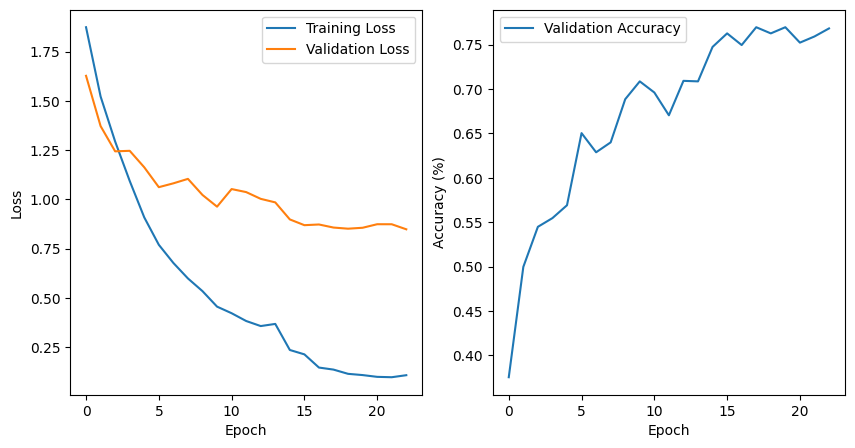

In [43]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

### Accuracy general

In [44]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy in the test set: {accuracy:.2f}%")

Accuracy in the test set: 75.36%


### Accuracy by class

In [45]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs) 
        _, predicted = torch.max(outputs, 1)  
        all_preds.extend(predicted.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=column_names, digits=4)  
print(report)

                                    precision    recall  f1-score   support

                Addictive disorder     0.6552    0.5938    0.6230        32
                  Anxiety disorder     0.7609    0.9211    0.8333        38
                   Healthy control     0.8125    0.7647    0.7879        34
                     Mood disorder     0.4773    0.4468    0.4615        47
     Obsessive compulsive disorder     0.9744    0.9744    0.9744        39
                     Schizophrenia     0.8409    0.7872    0.8132        47
Trauma and stress related disorder     0.7609    0.8140    0.7865        43

                          accuracy                         0.7536       280
                         macro avg     0.7546    0.7574    0.7543       280
                      weighted avg     0.7506    0.7536    0.7504       280



### Confusion matrix by class

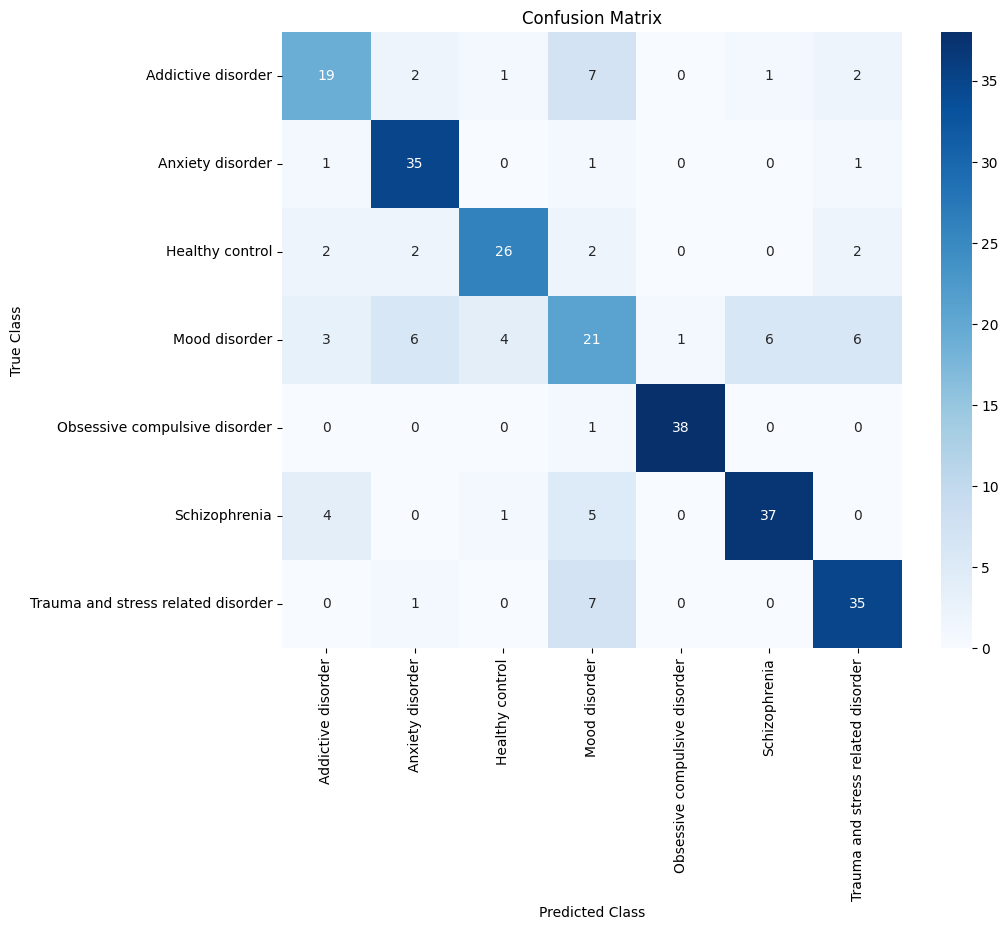

In [46]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Model outputs
            outputs = F.softmax(outputs, dim=1)  # Probs
            top_p, top_class = outputs.topk(k=1, dim=1)  # Pred class
            all_preds.extend(top_class.cpu().numpy())  # Preds
            all_labels.extend(labels.cpu().numpy())  # True class

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(f'Confusion Matrix')
    plt.show()


plot_confusion_matrix(model, test_loader, column_names)

### ROC Curves by Class

In [47]:
def evaluate_auc(model, test_loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(probs.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    aucs = []
    for i in range(num_classes):
        auc = roc_auc_score(all_labels == i, all_preds[:, i])
        aucs.append(auc)

    mean_auc = np.mean(aucs)
    
    print(f"AUC per class: {aucs}")
    print(f"Mean AUC: {mean_auc:.4f}")
    
    return aucs, mean_auc

aucs, mean_auc = evaluate_auc(model, test_loader, num_classes=7)

AUC per class: [0.888734879032258, 0.9735754675946064, 0.9401004304160689, 0.8114327458679572, 0.987871050111714, 0.9421970596292577, 0.9348444706113237]
Mean AUC: 0.9255


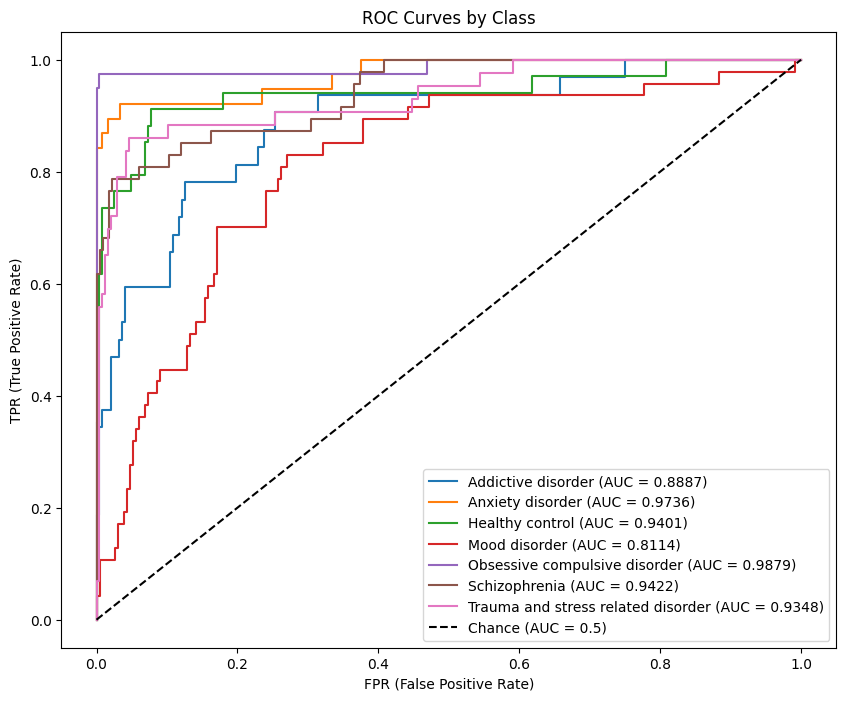

In [48]:
def plot_roc_curve(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(all_labels == i, all_preds[:, i])
        auc = roc_auc_score(all_labels == i, all_preds[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title('ROC Curves by Class')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(model, test_loader, column_names)

In [49]:
def log_results(filename, **kwargs):
    file_exists = os.path.isfile(filename)
    
    with open(filename, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=kwargs.keys())
        
        if not file_exists:
            writer.writeheader()
            
        writer.writerow(kwargs)
        
results_file = "results.csv"

log_results(
        results_file,
        final_epoch=final_epoch,
        number_of_neurons=selected_neurons,
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        batch_size=batch_size,
        dropout=dropout,
        learning_rate=float(learning_rate),
        output_dim=output_dim,
        input_dim=input_dim,
        aucs=aucs,
        mean_auc=mean_auc,
        report=report,
        accuracy=accuracy,
    )